In [13]:
# Setup and import all required libraries for data preprocessing.
# This includes standard libraries for image processing, data handling, and file management.

import os
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import io
import cv2

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define base project paths
BASE_DIR = Path("/content/drive/MyDrive/Cal_Estimation_Project/data")
RAW_DIR = BASE_DIR / "raw"
PROCESSED_DIR = BASE_DIR / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("Drive mounted and project directories ready.")
print("Raw data path:", RAW_DIR)
print("Processed data path:", PROCESSED_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted and project directories ready.
Raw data path: /content/drive/MyDrive/Cal_Estimation_Project/data/raw
Processed data path: /content/drive/MyDrive/Cal_Estimation_Project/data/processed


In [14]:
# ============================================================
# CACHE UTILITIES FOR NOTEBOOK 02
# Saves processed intermediate datasets for faster re-runs.
# ============================================================
import pickle   # <-- REQUIRED
CACHE_DIR = "/content/drive/MyDrive/Cal_Estimation_Project/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_cache(obj, name="02_cache"):
    path = f"{CACHE_DIR}/{name}.pkl"
    with open(path, "wb") as f:
        pickle.dump(obj, f)
    print(f"✔ Saved cache → {path}")

def load_cache(name="02_cache"):
    path = f"{CACHE_DIR}/{name}.pkl"
    if os.path.exists(path):
        print(f"✔ Loaded cache → {path}")
        with open(path, "rb") as f:
            return pickle.load(f)
    return None


In [15]:
# Load the dataset manifest created in Notebook 01.
from pathlib import Path
import json

possible_paths = [
    Path("/content/drive/MyDrive/Cal_Estimation_Project/manifests/datasets_manifest.json"),
    Path("/content/drive/MyDrive/Cal_Estimation_Project/data/manifests/datasets_manifest.json")
]

manifest_path = next((p for p in possible_paths if p.exists()), None)

if manifest_path is None:
    raise FileNotFoundError("Manifest not found. Please verify that Notebook 01 was run and manifests folder exists.")
else:
    with open(manifest_path, "r") as f:
        manifest = json.load(f)
    print(f"Loaded manifest from: {manifest_path}\n")
    print(json.dumps(manifest, indent=4))

# Extract dataset paths
foodseg_path = Path(manifest["FoodSeg103"])
nutrition5k_path = Path(manifest["Nutrition5k"])
usda_path = Path(manifest["USDA_FoodData"])


Loaded manifest from: /content/drive/MyDrive/Cal_Estimation_Project/data/manifests/datasets_manifest.json

{
    "FoodSeg103": "/content/drive/MyDrive/Cal_Estimation_Project/data/raw/foodseg103/FoodSeg103",
    "Nutrition5k": "/content/drive/MyDrive/Cal_Estimation_Project/data/raw/nutrition5k",
    "USDA_FoodData": "/content/drive/MyDrive/Cal_Estimation_Project/data/raw/usda"
}


In [16]:
def verify_dataset(name, path):
    if path.exists():
        files = list(path.glob("**/*"))
        print(f"{name}: {len(files)} files found at {path}")
    else:
        print(f"{name}: Folder not found at {path}")

print("Verifying dataset paths...\n")
verify_dataset("FoodSeg103", foodseg_path)
verify_dataset("Nutrition5k", nutrition5k_path)
verify_dataset("USDA FoodData", usda_path)
print("\nAll datasets verified.")


Verifying dataset paths...

FoodSeg103: 14250 files found at /content/drive/MyDrive/Cal_Estimation_Project/data/raw/foodseg103/FoodSeg103
Nutrition5k: 6 files found at /content/drive/MyDrive/Cal_Estimation_Project/data/raw/nutrition5k
USDA FoodData: 25 files found at /content/drive/MyDrive/Cal_Estimation_Project/data/raw/usda

All datasets verified.


Found 4983 training images and 4983 masks.


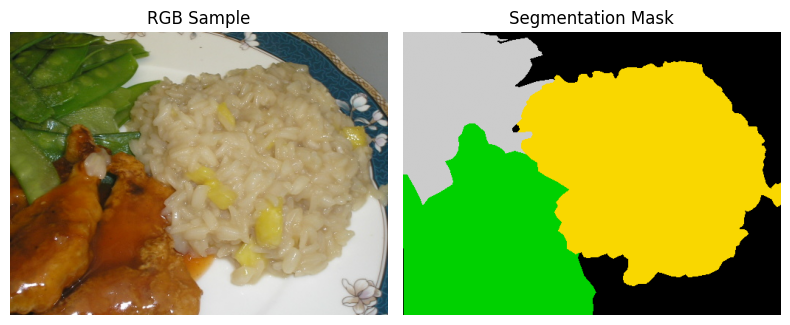

In [17]:
from PIL import Image
import random

img_dir = foodseg_path / "Images" / "img_dir" / "train"
mask_dir = foodseg_path / "Images" / "ann_dir" / "train"

image_files = sorted(list(img_dir.glob("*.jpg")))
mask_files = sorted(list(mask_dir.glob("*.png")))

print(f"Found {len(image_files)} training images and {len(mask_files)} masks.")

subset_pairs = [(img, mask_dir / (img.stem + ".png")) for img in image_files[:50]]

def load_image_pair(img_path, mask_path):
    img = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path))
    return img, mask

sample_img, sample_mask = load_image_pair(*subset_pairs[0])

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(sample_img); plt.title("RGB Sample"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(sample_mask, cmap="nipy_spectral"); plt.title("Segmentation Mask"); plt.axis("off")
plt.tight_layout(); plt.show()


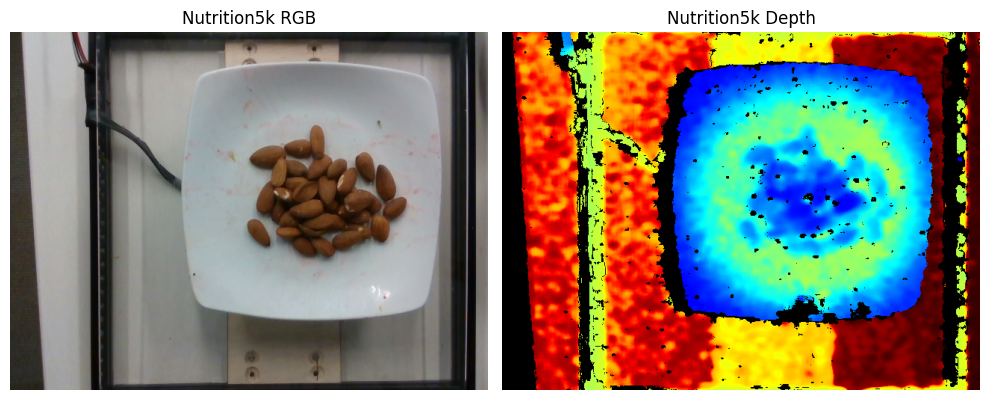

In [18]:
from PIL import Image
import io

nutrition_df = pd.read_excel(nutrition5k_path / "dishes.xlsx")
dish_pkl = pd.read_pickle(nutrition5k_path / "dish_images.pkl")

def decode_image_bytes(image_bytes):
    return np.array(Image.open(io.BytesIO(image_bytes)))

decoded_samples = []
for i in range(5):
    rgb_img = decode_image_bytes(dish_pkl.iloc[i]["rgb_image"])
    depth_img = decode_image_bytes(dish_pkl.iloc[i]["depth_image"])
    decoded_samples.append((rgb_img, depth_img))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(decoded_samples[0][0]); plt.title("Nutrition5k RGB"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(decoded_samples[0][1], cmap="gray"); plt.title("Nutrition5k Depth"); plt.axis("off")
plt.tight_layout(); plt.show()


In [19]:
food_csv = usda_path / "food.csv"
nutrient_csv = usda_path / "nutrient.csv"
food_nutrient_csv = usda_path / "food_nutrient.csv"

df_food = pd.read_csv(food_csv, usecols=["fdc_id", "description", "food_category_id"])
df_nutrient = pd.read_csv(nutrient_csv, usecols=["id", "name", "unit_name"])
df_food_nutrient = pd.read_csv(food_nutrient_csv, usecols=["fdc_id", "nutrient_id", "amount"])

merged = (df_food_nutrient
          .merge(df_nutrient, left_on="nutrient_id", right_on="id")
          .merge(df_food, on="fdc_id"))

key_nutrients = ["Energy", "Protein", "Total lipid (fat)", "Carbohydrate, by difference"]
df_usda_filtered = merged[merged["name"].isin(key_nutrients)]

print(f"Filtered USDA nutrient table: {df_usda_filtered.shape}")
display(df_usda_filtered.head())


Filtered USDA nutrient table: (6557, 8)


,fdc_id,nutrient_id,amount,id,name,unit_name,description,food_category_id
2,319877,1004,19.0,1004,Total lipid (fat),G,Hummus,16.0
16,319882,1004,18.7,1004,Total lipid (fat),G,Hummus,16.0
28,319892,1004,16.6,1004,Total lipid (fat),G,Hummus,16.0
43,319899,1004,19.1,1004,Total lipid (fat),G,Hummus,16.0
97,319908,1004,18.2,1004,Total lipid (fat),G,Hummus,16.0


In [20]:
df_usda_std = df_usda_filtered.loc[:, ["fdc_id", "description", "name", "amount", "unit_name"]].copy()

def standardize_units(row):
    if row["name"] == "Energy" and str(row["unit_name"]).lower() == "kj":
        return row["amount"] * 0.239006
    return row["amount"]

df_usda_std["amount_std"] = df_usda_std.apply(standardize_units, axis=1)

df_usda_pivot = (
    df_usda_std
    .pivot_table(index=["fdc_id", "description"],
                 columns="name", values="amount_std", aggfunc="mean")
    .reset_index()
)

df_usda_pivot.rename(columns={
    "Energy": "calories_kcal",
    "Protein": "protein_g",
    "Total lipid (fat)": "fat_g",
    "Carbohydrate, by difference": "carbs_g"
}, inplace=True)

print("Normalized USDA reference data (first 5 rows):")
display(df_usda_pivot.head())


Normalized USDA reference data (first 5 rows):


name,fdc_id,description,carbs_g,calories_kcal,protein_g,fat_g
0,319877,Hummus,NaN,NaN,NaN,19.0
1,319882,Hummus,NaN,NaN,NaN,18.7
2,319892,Hummus,NaN,NaN,NaN,16.6
3,319899,Hummus,NaN,NaN,NaN,19.1
4,319908,Hummus,NaN,NaN,NaN,18.2


In [21]:
complete_usda = df_usda_pivot.dropna(subset=["calories_kcal", "protein_g", "fat_g", "carbs_g"])
print(f"{len(complete_usda)} foods have complete macronutrient information.")
display(complete_usda.sample(5, random_state=42))


135 foods have complete macronutrient information.


name,fdc_id,description,carbs_g,calories_kcal,protein_g,fat_g
2152,746783,"Sausage, turkey, breakfast links, mild, raw",0.93,168.869118,16.70,10.40
1224,334849,"Beef, loin, top loin steak, boneless, lip-on, ...",0.00,154.937944,22.80,6.39
2318,747693,"Ketchup, restaurant",26.80,116.817464,1.11,0.55
370,324860,"Peanut butter, smooth style, with salt",22.30,597.257500,22.50,51.10
725,329490,"Egg, whole, dried",1.87,575.502230,48.10,39.80


In [22]:
import cv2
import numpy as np
from tqdm import tqdm

processed_foodseg = PROCESSED_DIR / "foodseg103_samples.npz"
processed_nutrition5k = PROCESSED_DIR / "nutrition5k_samples.npz"
processed_usda = PROCESSED_DIR / "usda_reference.csv"

TARGET_SIZE = (256, 256)

def resize_pair(image, mask, size=TARGET_SIZE):
    img_resized = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    return img_resized, mask_resized

resized_imgs, resized_masks = [], []
for img_path, mask_path in tqdm(subset_pairs, desc="Resizing FoodSeg103 samples"):
    img, mask = load_image_pair(img_path, mask_path)
    img_r, mask_r = resize_pair(img, mask)
    resized_imgs.append(img_r)
    resized_masks.append(mask_r)

np.savez_compressed(processed_foodseg,
                    images=np.array(resized_imgs),
                    masks=np.array(resized_masks))

np.savez_compressed(
    processed_nutrition5k,
    rgb=[x[0] for x in decoded_samples],
    depth=[x[1] for x in decoded_samples]
)

complete_usda.to_csv(processed_usda, index=False)

print("✅ Processed datasets saved successfully:")
print(f"- FoodSeg103 → {processed_foodseg}")
print(f"- Nutrition5k → {processed_nutrition5k}")
print(f"- USDA reference → {processed_usda}")


Resizing FoodSeg103 samples: 100%|██████████| 50/50 [00:01<00:00, 29.85it/s]


✅ Processed datasets saved successfully:
- FoodSeg103 → /content/drive/MyDrive/Cal_Estimation_Project/data/processed/foodseg103_samples.npz
- Nutrition5k → /content/drive/MyDrive/Cal_Estimation_Project/data/processed/nutrition5k_samples.npz
- USDA reference → /content/drive/MyDrive/Cal_Estimation_Project/data/processed/usda_reference.csv


In [23]:
if processed_foodseg.exists():
    data = np.load(processed_foodseg)
    print("FoodSeg103:", data["images"].shape, "images,", data["masks"].shape, "masks")

if processed_nutrition5k.exists():
    data = np.load(processed_nutrition5k)
    print("Nutrition5k:", len(data["rgb"]), "RGB images,", len(data["depth"]), "depth maps")

if processed_usda.exists():
    df = pd.read_csv(processed_usda)
    print("USDA Reference:", df.shape, "records")
    display(df.head())


FoodSeg103: (50, 256, 256, 3) images, (50, 256, 256) masks
Nutrition5k: 5 RGB images, 5 depth maps
USDA Reference: (135, 6) records


,fdc_id,description,carbs_g,calories_kcal,protein_g,fat_g
0,321358,"Hummus, commercial",14.90,229.222880,7.35,17.10
1,321359,"Milk, reduced fat, fluid, 2% milkfat, with add...",4.91,49.976127,3.35,1.90
2,321360,"Tomatoes, grape, raw",5.51,27.003839,0.83,0.63
3,321611,"Beans, snap, green, canned, regular pack, drai...",4.11,20.777258,1.04,0.39
4,321900,"Broccoli, raw",6.29,31.774396,2.57,0.34


In [24]:
# ============================================================
# SAVE CACHE FOR NOTEBOOK 02 (NEW)
# ============================================================

cache_data = {
    "foodseg_samples_path": str(processed_foodseg),
    "nutrition5k_samples_path": str(processed_nutrition5k),
    "usda_reference_path": str(processed_usda),
    "num_foodseg_samples": len(resized_imgs),
    "num_nutrition_samples": len(decoded_samples)
}

save_cache(cache_data, "02_cache")


✔ Saved cache → /content/drive/MyDrive/Cal_Estimation_Project/cache/02_cache.pkl
